In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
JAN_DATA = "data/fhv_tripdata_2021-01.parquet"
FEB_DATA = "data/fhv_tripdata_2021-02.parquet"


jan_data = pd.read_parquet(JAN_DATA)
feb_data = pd.read_parquet(FEB_DATA)

# Q1 Downloading the data
We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "For-Hire Vehicle Trip Records".

Download the data for January and February 2021.

Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".

Read the data for January. How many records are there?

 - 1054112
 - 1154112
 - 1254112
 - 1354112

In [3]:
jan_data.shape

(1154112, 7)

# Q2

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the average trip duration in January?

In [4]:
jan_data["duration"] = (jan_data["dropOff_datetime"] - jan_data["pickup_datetime"]).dt.total_seconds() / 60

In [5]:
jan_data["duration"].mean()

19.167224093791006

# Data preparation

Check the distribution of the duration variable. There are some outliers.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

<AxesSubplot:xlabel='duration'>

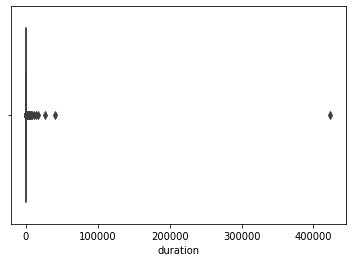

In [6]:
sns.boxplot(data=jan_data, x="duration")

In [7]:
filtered_jan_data = jan_data.query("duration >= 1 and duration <= 60")

In [8]:
jan_data.shape[0] - filtered_jan_data.shape[0]

44286

# Q3. Missing values

The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

 - 53%
 - 63%
 - 73%
 - 83%

In [9]:
(
    filtered_jan_data["PUlocationID"].isna().sum()/len(filtered_jan_data),
    filtered_jan_data["DOlocationID"].isna().sum()/len(filtered_jan_data)
)

(0.8352732770722617, 0.13327044059158824)

In [10]:
filtered_jan_data["PUlocationID"].fillna(-1, inplace=True)

/var/folders/xz/lh8h89515p57_vpg0mgc_ddc0000gn/T/ipykernel_76899/120719750.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_jan_data["PUlocationID"].fillna(-1, inplace=True)


In [11]:
filtered_jan_data["DOlocationID"].fillna(-1, inplace=True)

/var/folders/xz/lh8h89515p57_vpg0mgc_ddc0000gn/T/ipykernel_76899/2222967443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_jan_data["DOlocationID"].fillna(-1, inplace=True)


In [12]:
assert not filtered_jan_data["DOlocationID"].isna().all() and not filtered_jan_data["PUlocationID"].isna().all()

In [15]:
def prepare_dataframe(raw_data: pd.DataFrame) -> pd.DataFrame:
    data = raw_data.copy()
    
    # Translate data columns to datetimes.
    data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"])
    data["dropOff_datetime"] = pd.to_datetime(data["dropOff_datetime"])
    
    # Compute duration time in minutes.
    data["duration"] = (data["dropOff_datetime"] - data["pickup_datetime"]).dt.total_seconds() / 60
    
    # Filter data by duration.
    data = data.query("duration >= 1 and duration <= 60")
    assert (data["duration"] >= 1).all() and (data["duration"] <= 60).all()
    
    # Fill NaN's.
    data["PUlocationID"].fillna(-1, inplace=True)
    data["DOlocationID"].fillna(-1, inplace=True)
    assert not data["DOlocationID"].isna().all() and not data["PUlocationID"].isna().all()
    return data

In [16]:
jan_data = prepare_dataframe(jan_data)
feb_data = prepare_dataframe(feb_data)

/var/folders/xz/lh8h89515p57_vpg0mgc_ddc0000gn/T/ipykernel_76899/3759886052.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["PUlocationID"].fillna(-1, inplace=True)
/var/folders/xz/lh8h89515p57_vpg0mgc_ddc0000gn/T/ipykernel_76899/3759886052.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["DOlocationID"].fillna(-1, inplace=True)
/var/folders/xz/lh8h89515p57_vpg0mgc_ddc0000gn/T/ipykernel_76899/3759886052.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

# Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries

Fit a dictionary vectorizer

Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns).

- 2
- 152
- 352
- 525
- 725

In [17]:
from sklearn.feature_extraction import DictVectorizer


def get_x_and_y(data: pd.DataFrame, cat_features: list[str]) -> tuple[np.ndarray, np.ndarray]:
    vectorizer = DictVectorizer()
    train_dicts = data[cat_features].to_dict(orient='records')
    x = vectorizer.fit_transform(train_dicts)
    print("Design matrix dims:", x.shape)
    y = data["duration"].values
    return x, y


X_train, y_train = get_x_and_y(jan_data, cat_features=["DOlocationID", "PUlocationID"])
X_test, y_test = get_x_and_y(feb_data, cat_features=["DOlocationID", "PUlocationID"])

Design matrix dims: (1109826, 2)
Design matrix dims: (990113, 2)


# Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters

Calculate the RMSE of the model on the training data

What's the RMSE on train?

5.52
10.52
15.52
20.52

# Q6. Evaluating the model
Now let's apply this model to the validation dataset (Feb 2021).

What's the RMSE on validation?

6.01
11.01
16.01
21.01

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def train_and_validate(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray
) -> tuple[float, float]:
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    train_score = mean_squared_error(y_train, lr.predict(X_train), squared=False)
    val_score = mean_squared_error(y_val, lr.predict(X_val), squared=False)
    return train_score, val_score


print("Train: {}, val: {}".format(*train_and_validate(X_train, y_train, X_test, y_test)))

Train: 11.415432830521663, val: 11.85822362355935
